In [1]:
#GET DATA
import os
import pandas as pd

df = pd.read_csv("../../data/pruned/main_tags_songs.csv", sep=";")
df["lyric"] = ""
for ind in df.index:
    song_id = str(df["id"][ind]).zfill(7)
    with open(os.path.join("../../data/pruned/lyrics", song_id+".txt"), "r",encoding='utf-8') as src:
        lyric = src.read()
    df.loc[ind, "lyric"] = lyric
df.head()

,id,title,artists,langauge,genre,lyric
0,923602,I’m All She’s Got,George Jones,en,country,"Unhappy, well, I should say not\nIf somebody t..."
1,102711,The Last Time,& Taylor Swift,en,country,Find myself at your door\nJust like all those ...
2,3947017,Foolish One (Taylor's Version) [From The Vault],& Taylor Swift,en,country,"My cards are on the table, yours are in your h..."
3,782006,I Hurt For You,Deborah Allen,en,country,To think of all your love she's been denying\n...
4,907072,Dixie Cannonball,Hank Williams,en,country,That's the place I long to be\nWhere the cotto...


In [2]:
#DATA CLEANING
import re

#remove punctuation
df['lyric_processed'] = \
df['lyric'].map(lambda x: re.sub('[(),\.!?]', '', x))
#make lowercase
df['lyric_processed'] = \
df['lyric_processed'].map(lambda x: x.lower())
df['lyric_processed'].loc[1]

"find myself at your door\njust like all those times before\ni’m not sure how i got there\nall roads they lead me here\ni imagine you are home\nin your room all alone\nand you open your eyes into mine\nand everything feels better\n\n[pre-chorus: both]\nand right before your eyes\ni'm breaking no past\nno reasons why\njust you and me\n\n[chorus: both]\nthis is the last time i'm asking you this\nput my name at the top of your list\nthis is the last time i'm asking you why\nyou break my heart in the blink of an eye eye eye\n\n[verse 2: taylor swift]\nyou find yourself at my door\nand just like all those times before\nyou wear your best apology\nbut i was there to watch you leave\nand all the times i let you in\njust for you to go again\ndisappear when you come back\neverything is better\nyou might also like[pre-chorus: both]\nand right before your eyes\ni'm aching run fast\nnowhere to hide\njust you and me\n\n[chorus: both]\nthis is the last time i'm asking you this\nput my name at the to

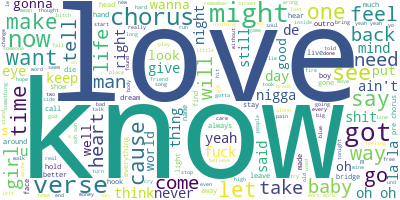

In [3]:
#WORDCLOUD AS EXTRAPOLARYY DATA ANALYSIS
from wordcloud import WordCloud

long_string = ','.join(list(df['lyric_processed'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [14]:
#CONTINUE CLEANING: What are still problems?
import langid
'''
Things to do:
1.) Need to filter out chorus, verse, pre-chorus, verse 4, ... all starts as a line with [
2.) Do I want stuff like oh oh or la la or na na or da da? Might remove them when removing stop words 
3.) de indicates the existance of some french texts in there: detect automatically
'''
#remove verse and stuff of form [ ... ]
pattern = r'\[(.*?)\]'
df['lyric_processed'] = \
df['lyric_processed'].map(lambda x: re.sub(pattern, '', x))

#remove line breaks
df['lyric_processed'] = \
df['lyric_processed'].map(lambda x: re.sub(r'\n', ' ', x))

#remove extra spaces
df['lyric_processed'] = \
df['lyric_processed'].map(lambda x: re.sub(' +', ' ', x))

#remove songs not in english language
for ind in df.index:
    text = df.loc[ind, "lyric_processed"]
    language = langid.classify(text)[0]
    if language != "en":
        df.drop(ind)
    

print(df['lyric_processed'].loc[0])
df['lyric_processed'].head()

yo se bien que estoy afuera pero el día que yo me muera se que tendrás que llorar dirás que no me quisiste pero vas a estar muy triste y así te vas a quedar con dinero y sin dinero hago siempre lo que quiero y mi palabra es la ley no tengo trono ni reyna ni nadie que me comprenca pero sigo siendo el rey me enseñó que mi destino era rodar y rodar despues me dijo un arriero que no hay que llegar primero pero hay que saber llegar con dinero y sin dinero hago siempre lo que quiero y mi palabra es la ley no tengo trono ni reyna ni nadie que me comprenca pero sigo siendo el reyyou might also like
 güvenemem servetime malıma ümidim yok bugün ile yarına toprak beni de basacak bağrına adaletin bu mu dünya ne yâr verdin ne mal dünya kötülerinsin sen dünya i̇yileri öldüren dünya adaletin bu mu dünya ne yâr verdin ne mal dünya kötülerinsin sen dünya i̇yileri öldüren dünya ne insanlar gelip geçti kapından memnun gelip giden var mı yolundan kimi fakir kimi ayrılmış yârinden adaletin bu mu dünya ne y

0    unhappy well i should say not if somebody told...
1    find myself at your door just like all those t...
2    my cards are on the table yours are in your ha...
3    to think of all your love she's been denying a...
4    that's the place i long to be where the cotton...
Name: lyric_processed, dtype: object

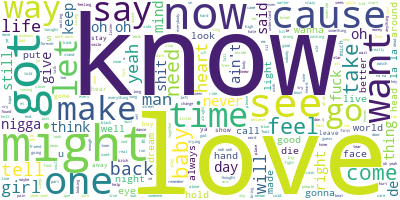

In [7]:
#WORDCLOUD AS EXTRAPOLARYY DATA ANALYSIS: Problems solved?
from wordcloud import WordCloud

long_string = ','.join(list(df['lyric_processed'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()


In [15]:
#PREPARE DATA FOR LDA
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora

stop_words = stopwords.words('english')
stop_words.extend(['from', 'la','oh','also', 'get', 'let', 'yeah', 'got', 'might', 'ooh','uh','chorus','verse'])
                  
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
def lyric_to_corpora(lyric_series):
    data = lyric_series.values.tolist()
    data_words = list(sent_to_words(data))
    data_words = remove_stopwords(data_words)
    #Create Dictionary
    id2word = corpora.Dictionary(data_words)
    #Create Corpus
    texts = data_words
    corpus = [id2word.doc2bow(text) for text in texts]
    return corpus, id2word

corpus, id2word = lyric_to_corpora(df.lyric_processed)
print(corpus[:2][0][:30])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]


In [16]:
#LDA FOR ALL GENRES
from pprint import pprint
# number of topics: same as number of categories
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"like" + 0.008*"love" + 0.007*"know" + 0.007*"go" + 0.006*"time" + '
  '0.005*"see" + 0.005*"baby" + 0.005*"cause" + 0.005*"de" + 0.004*"never"'),
 (1,
  '0.010*"know" + 0.007*"like" + 0.006*"de" + 0.005*"one" + 0.005*"go" + '
  '0.005*"time" + 0.005*"que" + 0.004*"say" + 0.004*"back" + 0.003*"love"'),
 (2,
  '0.017*"love" + 0.016*"like" + 0.009*"know" + 0.008*"baby" + 0.007*"want" + '
  '0.006*"one" + 0.006*"back" + 0.006*"come" + 0.006*"never" + 0.006*"time"'),
 (3,
  '0.022*"like" + 0.009*"know" + 0.006*"never" + 0.006*"love" + 0.005*"go" + '
  '0.005*"see" + 0.005*"cause" + 0.004*"way" + 0.004*"que" + 0.004*"tell"'),
 (4,
  '0.012*"like" + 0.011*"know" + 0.006*"baby" + 0.005*"love" + 0.005*"go" + '
  '0.005*"see" + 0.004*"girl" + 0.004*"way" + 0.004*"ich" + 0.004*"never"')]


In [ ]:
'''
First results:
- Very similar topics (mainly love, like, know) and therefore also similar words per topic
- que, de, ich: language detection not perfect
'''

In [20]:
#LDA with smaller alpha and eta for all genres
#Get very similar topics and words per topic --> make alpha smaller and eta smaller
from pprint import pprint
# number of topics: same as number of categories
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      alpha=1.0/ (100*num_topics),
                                      eta=1.0/( 100*num_topics))
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"like" + 0.014*"love" + 0.008*"know" + 0.007*"go" + 0.007*"make" + '
  '0.006*"baby" + 0.005*"gonna" + 0.005*"one" + 0.005*"say" + 0.004*"wanna"'),
 (1,
  '0.018*"like" + 0.018*"love" + 0.014*"know" + 0.007*"back" + 0.006*"time" + '
  '0.006*"night" + 0.005*"want" + 0.005*"cause" + 0.005*"baby" + 0.005*"tell"'),
 (2,
  '0.012*"like" + 0.009*"love" + 0.008*"know" + 0.007*"time" + 0.007*"one" + '
  '0.006*"see" + 0.005*"make" + 0.005*"feel" + 0.005*"wanna" + 0.005*"way"'),
 (3,
  '0.018*"like" + 0.010*"baby" + 0.009*"know" + 0.006*"see" + 0.006*"never" + '
  '0.006*"time" + 0.006*"go" + 0.005*"want" + 0.005*"back" + 0.005*"cause"'),
 (4,
  '0.011*"like" + 0.011*"know" + 0.008*"never" + 0.007*"one" + 0.006*"work" + '
  '0.006*"love" + 0.006*"go" + 0.006*"say" + 0.005*"de" + 0.005*"come"')]


In [ ]:
'''
- Nicht viel besser was die Unterschiedlichkeit der topics angeht, auch wenn man die Parameter ins extrem zieht
'''

In [21]:
#LDA PER GENRE: Can we see a difference here? Is there potential for the common lda to separate between genres?

num_topics = 5
genres = list(set(df.genre.values))
for genre in genres:
    #Get genre-data
    print("GENRE: "+str(genre))
    df_genre = df[df["genre"]==genre]
    corpus, id2word = lyric_to_corpora(df_genre.lyric)
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      alpha=1.0/ (100*num_topics),
                                      eta=1.0/(100*num_topics))
    pprint(lda_model.print_topics())
    

GENRE: pop
[(0,
  '0.012*"like" + 0.012*"know" + 0.009*"love" + 0.008*"que" + 0.008*"go" + '
  '0.006*"baby" + 0.006*"te" + 0.006*"come" + 0.006*"never" + 0.005*"de"'),
 (1,
  '0.014*"like" + 0.009*"know" + 0.006*"one" + 0.006*"ya" + 0.006*"tell" + '
  '0.005*"baby" + 0.005*"come" + 0.005*"love" + 0.005*"que" + 0.005*"time"'),
 (2,
  '0.011*"que" + 0.009*"like" + 0.009*"love" + 0.008*"de" + 0.007*"hey" + '
  '0.007*"see" + 0.006*"come" + 0.005*"go" + 0.005*"tu" + 0.005*"know"'),
 (3,
  '0.016*"love" + 0.011*"de" + 0.011*"like" + 0.007*"know" + 0.007*"que" + '
  '0.007*"go" + 0.006*"gonna" + 0.006*"one" + 0.006*"en" + 0.005*"come"'),
 (4,
  '0.016*"like" + 0.009*"love" + 0.009*"away" + 0.008*"know" + 0.008*"time" + '
  '0.006*"feel" + 0.006*"de" + 0.005*"want" + 0.005*"que" + 0.005*"go"')]
GENRE: r-b
[(0,
  '0.020*"know" + 0.019*"love" + 0.018*"like" + 0.012*"feel" + 0.011*"hey" + '
  '0.010*"cause" + 0.010*"tell" + 0.010*"way" + 0.010*"ayy" + 0.008*"go"'),
 (1,
  '0.026*"love" + 0.018*

In [ ]:
'''
Results:
- like love know actually dominant in every genre
- Difference:
    - pop: 
    - r-b: baby, back, work, wanna see
    - rock: 
    - rap: different language: fuck, shit, nigga, bitch. One topic about death
    - country: 
- Per genre, all topics are again very similar. Sign for too many topics? Other parameter configuration maybe useful? 

'''